
# [국회 입법 활동 빅데이터 시각화]  - v1.0
  

  
이번 기회를 통해 입법 활동에서의 활동 형태와 발의되는 법안의 주제가 무엇인지 확인해보고자 합니다. 추가적으로는 데이터 시각화를 통해 왜 그런 형태가 나타나는 지 추측/판단해보기로 했습니다. 참고로 특정 정당/정부에 대한 부정적인 의도는 없으며 추론 과정은 역사적 사실에 기반하고 있습니다.  
  
### keyword:
- 발의 법안 처리상태
- 시각화: cufflinks, plotly, wordCloud
  - interactive한 그래프를 사용했습니다.
- 본회의까지 간 국회의원 발의법의안은 어떻게 되었을까?
- 본회의 처리 안건의 법안명
  
.  
.  
##### * *아직 최종본이 아니기때문에 Ⅱ-4. 항목 추가 업데이트 예정입니다. *

---

# "프롤로그"  
- [프롤로그로 이동](#프롤로그)


### - 역대 국회의원들의 출생지(본관)
  
# Ⅰ. 본회의 처리 안건과 국회의원 발의법의안 살펴보기  
  1. 본회의 처리 안건   
    1.1 [의안활동구분은 국회별 차이가 있을까?](#의안활동구분은)     
    1.2 [21대 국회의 예산안 특이사항 확인하기](#예산안)    
  2. 국회의원 발의법의안  
    2.1 [국회의원들이 발의한 법안들은 어떻게 처리되었을까?](#국회의원들이)  
    2.2 [임기만료폐기 건의 국회별 건수 확인하기](#임기만료폐기)  
    2.3 [역대 국회에서 처리상태별 건수 및 비율](#역대)
  
# Ⅱ. 본회의 처리안건, 국회의원 발의법의안 간 차이  
  1. [국회의원 발의 법의안 중 본회의까지 가서 처리된 안건의 비중 확인하기](#국회의원)  
  2. [본회의 처리 안건 중 국회의원 발의법의안의 비중 확인하기](#본회의)  
  3. [본회의에서 처리한 안건의 가결률은?](#가결률)  
    - 국회의원이 발의한 법안과 그외의 법안으로 구분한 가결률  
  4. [본회의 처리 안건의 법안명 분석](#법안명)  
  
# Ⅲ. 마무리 
- [마무리로 이동](#마무리)
_______

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hanja
from wordcloud import WordCloud
import random
import matplotlib.font_manager as fm
import matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from konlpy.tag import Kkma
# from gensim.models import Word2Vec
import networkx as nx
import seaborn as sns
import cufflinks as cf 
from collections import Counter
import plotly.io as pio

cf.go_offline(connected = True)
cf.set_config_file(offline=True)
pio.renderers.default = 'notebook_connected'

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/H2GTRE.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

people = pd.read_csv("new_people.csv", encoding='cp949')
suggest = pd.read_csv("suggest.csv", encoding='utf-8')
process = pd.read_csv("process.csv", encoding='utf-8')

people.head()
people.columns

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (2,5,17) have mixed types.Specify dtype option on import or set low_memory=False.



Index(['DAESU', 'DAE', 'DAE_NM', 'NAME', 'NAME_HAN', 'JA', 'HO', 'BIRTH',
       'BON', 'POSI', 'HAK', 'HOBBY', 'BOOK', 'SANG', 'DEAD', 'URL'],
      dtype='object')

_____
<a id ='프롤로그'></a>
## 프롤로그_역대 국회의원들의 출생지(본관)
 출생지를 기준으로 할 경우 지역명이 제각각이었습니다. (과거 북한 지명 포함)  
 이를 배제하여 비교적 정리가 된 본관을 기준으로 각자의 고향을 판단하기로 하였습니다.  
 본관이 존재하는 데이터도 전체 데이터의 약 50%정도였으나 이를 바탕으로 출신을 확인해보겠습니다.  
   
> - 확인 결과 김해, 밀양, 전주, 경주, 진주 등 경상도와 전라도 지역 출신이 다수였음을 확인할 수 있었습니다. 

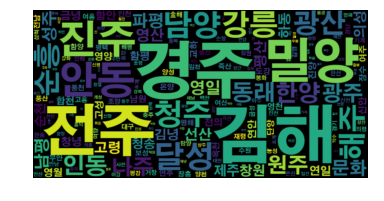

In [4]:
sum(people['BON'].isna()) #전체 인원 중 약 50%는 본관 확인 불가

people_sub = people[-people['BON'].isna()]
people_sub = people_sub.reset_index(drop=True)

# "경남 진주"와 같이 혼재되어 있어 앞의 두 글자만을 본관으로 딴다. 한자의 경우 해석.
people_sub['BON'] = [people_sub['BON'][x][:2] for x in range(len(people_sub))]
people_sub['BON'] = [hanja.translate(people_sub['BON'][x], 'substitution') for x in range(len(people_sub))]
people_sub['BON'] = [people_sub['BON'][x].strip() for x in range(len(people_sub))]

random.seed(1)
sub_data = people_sub['BON'].value_counts()
wc=WordCloud(font_path='C:/Windows/Fonts/H2GTRE.ttf',max_font_size=150, width=800, height=400).generate_from_frequencies(sub_data)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

# Ⅰ. 본회의 처리 안건과 국회의원 발의법의안 살펴보기
 법안은 국회의원들의 업무 방식, 국민들의 생활과 밀접한 관계를 가지는 사항입니다. 법안을 통해 본회의와 국회의원 발의법의안의 처리상태 및 종류를 살펴보겠습니다.  
 
## 1. 본회의 처리 안건(dataset: process) 

  process dataset에서 국회 대수, 의안활동구분, 처리결과('AGE','BILL_KIND','PROC_RESULT_CD')의 경우 결측값은 데이터 셋에서 제외합니다. 

In [5]:
def drop_nas(df, variable): #dataframe에서 na있는 변수drop
    df = df[-df[variable].isna()]
    return df

process_sub = drop_nas(process, 'AGE')
process_sub = drop_nas(process_sub, 'BILL_KIND')   
process_sub = drop_nas(process_sub, 'PROC_RESULT_CD')  

df = pd.DataFrame(process.groupby(by=['AGE','BILL_KIND'], as_index=False).size())
df = df.reset_index()
df.columns = ["age","bill_kind","count"]

<a id='의안활동구분은'></a>  

## 1.1 의안활동구분은 국회별 차이가 있을까?
국회별 의안활동구분(BILL_KIND) 건수를 계산하고, 각 국회에서 각 의안활동의 비중을 계산합니다.  
  
국회별 본회의에서 처리되는 법안 중 법률안 처리 건수는 지속적으로 증가했고, 17대 국회 이후 급격히 증가해왔습니다.  
비중으로 봤을 때에는 대부분의 국회에서 법률안의 비중이 가장 컸습니다. 하지만 최근 21대 국회에 와서 예산안 비율이 상대적으로 커졌음을 확인할 수 있었습니다. 21대 국회 본회의에서 처리된 예산안은 21대 국회에서만 유독 높은 것일까요?

In [6]:
def get_ratio(df,lst):  #변수별 비율값 계산 함수
    dataframe = df.copy()
    dataframe['sum'] = dataframe[lst].sum(axis=1)
    for x in lst:
        dataframe[x] = dataframe[x] / dataframe['sum']
    return dataframe

df = df.pivot_table(values='count',index=df.age,columns=df.bill_kind)
df = df.fillna(0)
df['sum'] = df.sum(axis=1)

#비율기준값으로 계산
df_ratio = get_ratio(df, ['결산','기타','법률안','예산안'])

In [7]:
df[['결산',"기타","법률안","예산안"]].iplot(kind="bar", barmode='stack', title='국회별 본회의에서 처리되는 처리 안건 "건수" 비교')
df_ratio[['결산',"기타","법률안","예산안"]].iplot(kind="bar", barmode='stack',title='국회별 본회의에서 처리되는 처리 안건 "비율" 비교')

<a id='예산안'></a>
## 1.2 21대 국회의 예산안 특이사항 확인하기
  
- 21대 국회는 2020년 5월 30일부터 시작된 국회로 현재 임기 중이며 임기만료 예정일은 2024년 5월 29일입니다.  
- 국회별 예산안 건수를 확인하여 임기초반이라 예산안 비중이 높은 것인지 확인해보겠습니다.  
  
> - 예산안 건수는 20대 국회를 제외한 모든 국회에서의 건수보다 많습니다. 이는 아직 임기가 진행 중임을 감안했을 때 유독 예산안 건수가 많음을 의미합니다.  
> - 또한 임기의 반이 지나지 않았으나 이미 지난 국회(20대 국회)의 예산안 건수의 50%정도를 차지합니다.  
> ⇒ 21대 국회에서 "왜" 유독 예산안 관련 법안 건수가 많았을까요?

In [8]:
df.reset_index(inplace=True)

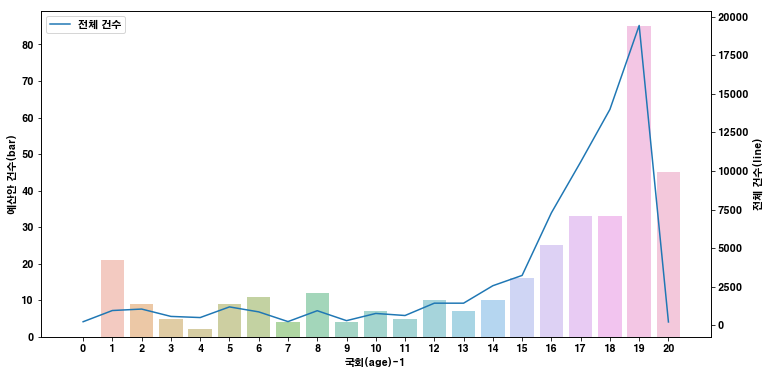

In [9]:
fig, ax1 = plt.subplots(figsize=(12,6))
g = sns.barplot(x=df.index,y="예산안",data=df, ax=ax1, alpha=0.5)
ax1.set_ylabel("예산안 건수(bar)")
ax1.set_xlabel("국회(age)-1")
ax2 = ax1.twinx()
g = sns.lineplot(x=df.index, y='sum', data=df, ax=ax2)
ax2.set_ylabel("전체 건수(line)")
ax2.legend(["전체 건수"])
plt.show()

### 21대 국회의 예산안의 법안명을 확인
  
> - 확인 결과 주된 예산안 내용은 '계획변경안'이 45건 중 43건으로 대다수를 차지한다는 것을 알 수 있습니다. 이는 20년 초(2,3월) 코로나로 인하여 기존에 할당된 예산을 변경하고자 했다고 추측됩니다.  
> - 또한 공포일(ANNOUNCE_DT)이 결측값이라 법안이 진행되지 않았다고 처음에 판단했으나, 조사결과 예산안은 ***국회의 의결이 효력발생요건***이라는 것을 확인했습니다. 즉, 본회의 심의 의결일이 존재하고 총투표수에서 찬성표가 모두 과반수 이상이었으니 예산안 변경이 이미 이루어진 셈입니다.

In [10]:
print("*계획 변경안 법안 수: ",process_sub[(process_sub['AGE']==21) & (process_sub['BILL_KIND']=='예산안')]['BILL_NAME'].str.count('계획변경안').sum())
process_sub[(process_sub['AGE']==21) & (process_sub['BILL_KIND']=='예산안')]['BILL_NAME']

*계획 변경안 법안 수:  43


39                2020년도 고용보험기금운용계획변경안(정부)
40            2020년도 소상공인시장진흥기금운용계획변경안(정부)
41                2020년도 기술보증기금운용계획변경안(정부)
42       2020년도 중소벤처기업창업 및 진흥기금운용계획변경안(정부)
43              2020년도 공공자금관리기금운용계획변경안(정부)
44                2020년도 신용보증기금운용계획변경안(정부)
45                  2020년도 제4회 추가경정예산안(정부)
177               2020년도 양성평등기금운용계획변경안(정부)
178              2020년도 청소년육성기금운용계획변경안(정부)
179               2020년도 주택도시기금운용계획변경안(정부)
180             2020년도 근로복지진흥기금운용계획변경안(정부)
181        2020년도 산업재해보상보험및예방기금운용계획변경안(정부)
182       2020년도 장애인고용촉진및직업재활기금운용계획변경안(정부)
183               2020년도 고용보험기금운용계획변경안(정부)
184               2020년도 국민연금기금운용계획변경안(정부)
185               2020년도 응급의료기금운용계획변경안(정부)
186             2020년도 국민건강증진기금운용계획변경안(정부)
187           2020년도 소상공인시장진흥기금운용계획변경안(정부)
188               2020년도 기술보증기금운용계획변경안(정부)
189        2020년도 중소벤처기업창업및진흥기금운용계획변경안(정부)
190           2020년도 방사성폐기물관리기금운용계획변경안(정부)
191               2020년도 무역보험기금운용계획변경안(정부)
192             2020년도 전력산업기반기금운용계획변경안(정부)
193        

<a id='국회의원 발의법의안'></a>
## 2. 국회의원 발의법의안

<a id='국회의원들이'></a>
### 2.1 국회의원들이 발의한 법안들은 어떻게 처리되었을까?
suggest dataset은 국회의원이 직접 발의한 법안들입니다. 먼저 처리상태(PROC_RESULT)를 확인하여 분포를 확인해보겠습니다.  

In [14]:
# 변수별 결측값 확인
print(suggest.isnull().sum())

BILL_ID             0
BILL_NO             0
BILL_NAME           0
COMMITTEE         837
PROPOSE_DT          7
PROC_RESULT      3816
AGE                 0
DETAIL_LINK         0
PROPOSER            1
MEMBER_LIST         0
RST_PROPOSER       92
PUBL_PROPOSER    2708
dtype: int64


## 국회별 처리상태를 확인한 결과 "임기만료폐기" 건이 압도적으로 다수를 차지했고 그 다음으로 "대안반영폐기" 가 2위를 차지했습니다.   
*** (참고) 대안반영폐기: 해당 법안이 다른 법의 일부 또는 전부에 포함되거나 반영되면 기존의 법안은 폐기함 (법안 자체가 폐기되는 것은 아님.) ***

In [15]:
temp = pd.DataFrame(suggest.groupby(by=['PROC_RESULT']).size()).reset_index()
temp.columns=['result','value']

result  value
0     대안반영폐기  15479
1         부결     23
2  비상국무회의로이관     30
3       수정가결   3189
4    수정안반영폐기     41
5       원안가결   1629
6     임기만료폐기  34736
7         철회   1181
8         폐기   2306
9    회기불계속폐기    228

In [16]:
suggest['PROC_RESULT'].iplot(kind='histogram', title="처리상태별 건수 비교")

<a id='임기만료폐기'></a>
## 2.2 임기만료폐기 건의 국회별 건수 확인하기
  
국회에서 임기만료폐기 건이 가장 큰 비중을 차지한다는 것을 확인했습니다. 이는 법안이 제대로 처리되기도 전에 법안을 발의한 국회의원의 임기가 만료되어 법안자체가 자동 폐기되는 것을 의미합니다. 사유는 다양하겠지만(법안 처리 지연, 국회의원의 직위해제, 무분별한 발의 및 제안...) 비효율적인 법안처리인 것으로 판단됩니다. 국회에서 발의한 법안이 얼만큼 본회의로까지 이어지는 지는 뒤에서 확인해려고 합니다.([->이동](#국회의원))     

먼저, 임기만료폐기 건이 과거부터 지속되어온 상황인지 파악하기 위해 국회별 임기만료폐기 건수를 확인했습니다. 그 결과 최근 국회(17대, 18대) 이후로 임기만료폐기 건은 지속적으로 증가해온 것을 알 수 있습니다. 참고로 21대 국회는 임기 초라는 것을 감안했을 때 임기만료폐기 건은 0건인 것이 당연합니다.

In [17]:
suggest[suggest['PROC_RESULT']=="임기만료폐기"]['AGE'].iplot(kind='histogram', title="국회별 임기만료폐기건수 비교")

<a id='역대'></a>
## 2.3 역대 국회에서 처리상태별 건수 및 비율

> - 건수만 비교했을 때에는 17대 국회부터 임기만료폐기 건이 급격히 증가했습니다.
> - 비율도 고려했을 때에는 6대 국회부터 임기만료폐기 건 비중이 두드러집니다.
> - 의외로 8대 국회에서 "비상국무회의로이관" 건의 비중이 약 73%로 압도적으로 많아 확인해보았습니다. 
  - 8대 국회
    - 임기기간: 1971년 7월 26일 ~ 1972년 10월 17일
    - 제 3공화국으로 박정희 전 대통령이 임기했음을 확인
    - **당시 집권했던 정부의 영향력으로 판단됨**

In [18]:
suggest_ratio = pd.DataFrame(suggest.groupby(by=['AGE','PROC_RESULT'], as_index=False).size())
suggest_ratio.reset_index(inplace=True)
suggest_ratio = suggest_ratio.fillna(0)
suggest_ratio.columns = ['AGE','PROC_RESULT','count']
suggest_ratio = suggest_ratio.pivot_table(values="count",index=suggest_ratio.AGE, columns=suggest_ratio.PROC_RESULT)
suggest_ratio = suggest_ratio.fillna(0)

In [19]:
suggest_ratio.iplot(kind="bar",title="국회별 처리상태 '건수' 비교", barmode='stack' )

proc_result = suggest_ratio.columns.values
suggest_ratio = get_ratio(suggest_ratio, proc_result)

suggest_ratio[suggest_ratio.columns.difference(['sum'])].iplot(kind="bar", title="국회별 처리상태 '비율' 비교", barmode='stack')

___________________________________________________________________________________________
# Ⅱ. 본회의 처리안건, 국회의원 발의법의안 간 차이  

<a id='국회의원'></a>
## 1. 국회의원 발의 법의안 중 본회의까지 가서 처리된 안건의 비중 확인하기   
  
국회의원 발의법의안(suggest dataset)와 본회의 처리안건(process dataset)의 의안ID를 기준으로 본회의까지 간 국회의원 발의법의안을 확인합니다.   
본회의 처리안건의 수는 68530건, 국회의원 발의법의안 중 본회의까지 올라간 안건의 수는 36980건이었습니다. **즉 역대 국회에 있어서 본회의 처리 안건 중 약 53.3%는 국회의원이 발의한 법안이었습니다.**    
  
위에서 국회에서 발의되는 법안들은 점차 임기만료폐기 건이 증가하는 추세였습니다. 과연 국회가 본회의로까지 이어지는 법안을 발의하고 있는 지 살펴보겠습니다.  

In [2]:
# suggest, process 각각의 데이터 셋에서 BILL_ID 변수의 타입이 달라 맞춰줌
suggest['BILL_ID'] = [int(suggest.loc[i, 'BILL_ID']) if suggest.loc[i, 'BILL_ID'].isnumeric() else suggest.loc[i, 'BILL_ID'] for i in range(len(suggest)) ]
suggest['BILL_ID'] = suggest['BILL_ID'].astype('str')
suggest['is_suggest'] = 1

process['BILL_ID'] = process['BILL_ID'].astype('str')
process['is_process'] = 1

여기에서 주목할 만한 점은 6대 국회~16대 국회까지 본회의에서 처리된 안건은 국회에서 상정된 건이 없다는 점입니다. 그렇다면 국회에서 발의한 법안이 1건도 없었던 것일까요?

In [4]:
in_process = pd.merge(process, suggest, how='left', on='BILL_ID')
in_process['is_suggest'] = in_process['is_suggest'].fillna(0)
in_process['is_suggest'] = ['국회에서 상정됨' if in_process.loc[x,'is_suggest'] == 1 else '본회의로 바로 상정됨' for x in range(len(in_process))]
in_process = pd.DataFrame(in_process.groupby(by=['AGE_x','is_suggest']).size())
in_process.reset_index(inplace=True)
in_process.columns = ['age','구분','count']
in_process = in_process.pivot_table(values='count',index=in_process.age,columns='구분')
in_process.fillna(0, inplace=True)
in_process['from_국회'] = in_process['국회에서 상정됨']/in_process.sum(axis=1)

in_process[['국회에서 상정됨','본회의로 바로 상정됨']].iplot(title='국회에서 상정된 건과 본회의로 바로 상정된 건 비교',xTitle='국회 대수',yTitle='건수')

In [6]:
in_process_sub = pd.DataFrame(in_process.sum(axis=0))
in_process_sub = in_process_sub[:2]
in_process_sub.columns = ['count']
in_process_sub.reset_index(inplace=True)

> - 전체 국회(1~21대)에서 본회의에서 처리된 안건 중 약 54%가 국회에서 상정되었음을 알 수 있습니다. 이는 본회의에서 처리되는 안건 중 과반수는 국회에서 발의된 법안이라는 것을 의미합니다.

In [23]:
in_process_sub.iplot(kind='pie',values='count', labels='구분', title='역대 본회의에서 처리된 안건 기준')

<a id='본회의'></a>
# 2. 본회의 처리 안건 중 국회의원 발의법의안의 비중 확인하기
  
6대 국회~16대 국회에서 발의한 법안이 없었을지 확인해보겠습니다.  
해당 국회에서는 최소 5건 이상의 법안들이 발의되었으나 본회의로 이어지지 않았습니다. 국회에서 법안을 발의했음에도 본회의로 상정되지 못한 이유를 알아보았습니다.   
  
  - 6대 국회: 1963.12.17 ~ 1967.06.30 (제 3공화국-박정희 정부)
  - 7대 국회: 1967.07.01 ~ 1971.06.30 (제 3공화국-박정희 정부)
  - 8대 국회: 1971.07.01 ~ 1972.10.17 (제 3공화국-박정희 정부)
  - 9대 국회: 1973.03.12 ~ 1979.03.11 (제 4공화국-박정희 정부)
  - 10대 국회: 1979.03.12 ~ 1980.10.27 (제 4공화국-최규하 정부)
  - 11대 국회: 1981.04.11 ~ 1985.04.10 (제 5공화국-전두환 정부)
  - 12대 국회: 1985.04.11 ~ 1988.05.29 (제 5공화국-전두환 정부)
  - 13대 국회: 1988.05.30 ~ 1992.05.29 (제 6공화국-노태우 정부)
  - 14대 국회: 1992.05.30 ~ 1996.05.29 (제 6공화국-노태우, 김영삼 정부)
  - 15대 국회: 1996.05.30 ~ 2000.05.29 (제 6공화국-김영삼, 김대중 정부)
  - 16대 국회: 2000.05.30 ~ 2004.05.29 (제 6공화국-김대중, 노무현 정부)
  
해당 국회들은 대부분 독재 집권과 관련이 있었으며, 정치적 혼란기에 있었던 시기였기에 국회에서 발의된 법안이 본회의까지 이어지는 데 어려움이 있었을 것이라 판단했습니다.

In [7]:
in_suggest = pd.merge(suggest, process, how='left', on='BILL_ID')
in_suggest['is_process'] = in_suggest['is_process'].fillna(0)
in_suggest['is_process'] = ['본회의로 상정됨' if in_suggest.loc[x,'is_process'] == 1 else '국회에서만 발의됨' for x in range(len(in_suggest))]
in_suggest = pd.DataFrame(in_suggest.groupby(by=['AGE_x','is_process']).size())
in_suggest.reset_index(inplace=True)
in_suggest.columns = ['age','구분','count']
in_suggest = in_suggest.pivot_table(values='count',index=in_suggest.age,columns='구분')
in_suggest.fillna(0, inplace=True)
in_suggest['to_본회의'] = in_suggest['본회의로 상정됨']/in_suggest.sum(axis=1)

in_suggest[['국회에서만 발의됨','본회의로 상정됨']].iplot(title='국회에서만 발의된 건수와 본회의로 상정된 건수 비교',xTitle='국회 대수',yTitle='건수')

In [8]:
in_suggest_sub = pd.DataFrame(in_suggest.sum(axis=0))
in_suggest_sub = in_suggest_sub[:2]
in_suggest_sub.columns = ['count']
in_suggest_sub.reset_index(inplace=True)

In [26]:
in_suggest_sub.iplot(kind='pie',values='count', labels='구분', title='역대 국회에서 발의된 법안 결과')

## 본회의 안건 중 국회에서 온 발의안 비율 vs 국회->본회의로 간 발의안 비율

In [27]:
df = pd.concat([in_process['from_국회'], in_suggest['to_본회의']], axis=1)
df.columns = ['본회의 안건 중 국회에서 온 비율','국회 발의안 중 본회의로 간 비율']
df.iplot(yTitle='비율', xTitle='국회(AGE)',title='국회별 비교')

### 위에서 보았듯이 국회에서 발의한 법안 상당 부분이 특히 최근들어서 본회의로 상정되는 수가 증가했습니다. 수많은 법안들이 국회의원들을 통해 가는데, 그 중 얼마나 가결될까요?

<a id='가결률'></a>
## 3. 본회의에서 처리한 안건의 가결률은?
### - 국회의원이 발의한 법안과 그외의 법안으로 구분한 가결률  
  
가결률은 국회 발의안(BY 의원 발의)와 그 외 발의안으로 구분하여 가결률을 보겠습니다.   
  
### 가결의 기준
          '원안가결'         ┐
          '수정가결'         │ ⇒ '가결'  로 분류
          '채택'             │
          '가결'             ┘
                  
                  
          위 항목 외 나머지     ⇒ '그 외' 로 분류

In [10]:
process_df = pd.merge(process, suggest, how='left', on='BILL_ID')
process_df['is_suggest'] = process_df['is_suggest'].fillna(0)
process_df['is_suggest'] = process_df['is_suggest'].astype('int').astype(str)
process_df['PROC_RESULT_CD'].value_counts()

임기만료폐기       36841
원안가결         16291
수정가결          7208
폐기            2874
대안반영폐기        2459
철회            1415
회기불계속폐기        911
부결             217
비상국무회의로이관      106
불허가             82
반려              75
수정안반영폐기         24
채택               4
불승인              3
부동의              3
가결               2
심사대상제외           2
각하               2
의결불요             2
Name: PROC_RESULT_CD, dtype: int64

In [11]:
process_df['PROC_RESULT_CD'] = process_df['PROC_RESULT_CD'].replace({'원안가결':'가결',
                                                                    '수정가결':'가결',
                                                                    '폐기':'그 외',
                                                                    '대안반영폐기':'그 외',
                                                                    '철회':'그 외',
                                                                    '회기불계속폐기':'그 외',
                                                                    '부결':'그 외',
                                                                    '비상국무회의로이관':'그 외',
                                                                    '불허가':'그 외',
                                                                    '반려':'그 외',
                                                                    '수정안반영폐기':'그 외',
                                                                    '채택':'가결',
                                                                    '부동의':'그 외',
                                                                    '불승인':'그 외',
                                                                    '의결불요':'그 외',
                                                                    '심사대상제외':'그 외',
                                                                    '가결':'가결',
                                                                    '각하':'그 외',
                                                                    '임기만료폐기':'그 외'})
process_df['PROC_RESULT_CD'].value_counts()

그 외    45016
가결     23505
Name: PROC_RESULT_CD, dtype: int64

### 역대 본회의에서 가결된 건과 그렇지 않은 건의 비율  
> - 역대 본회의에서 모든 법안 기준 가결률은 34.3%를 차지합니다.   
> ⇒ 과연 국회의원이 발의한 법안과 그렇지 않은 법안의 가결률과 해당 비율과 비슷할까요??

In [12]:
t = pd.DataFrame(process_df['PROC_RESULT_CD'].value_counts())
t.reset_index(inplace=True)
t.columns = ['구분','건수']
t.iplot(kind='pie',values='건수',labels='구분',title='역대 본회의에서 가결된 건과 그렇지 않은 건수 비교')
del t

In [13]:
t = process_df.copy()
t['is_suggest'] = t['is_suggest'].replace({'1':'국회의원로부터 상정',
                                          '0':'본회의로 바로 상정'})
t = pd.DataFrame(t.groupby(['AGE_x','is_suggest','PROC_RESULT_CD']).size())
t.reset_index(inplace=True)
t.columns = ['age','is_suggest','result','count']
t = t.pivot_table(values='count',index='age',columns=['is_suggest','result'])
t = t.fillna(0)

In [32]:
t[('국회의원로부터 상정','가결률')] = t[('국회의원로부터 상정','가결')] / t[[('국회의원로부터 상정','가결'),('국회의원로부터 상정','그 외')]].sum(axis=1)
t[('본회의로 바로 상정','가결률')] = t[('본회의로 바로 상정','가결')] / t[[('본회의로 바로 상정','가결'),('본회의로 바로 상정','그 외')]].sum(axis=1)
t.fillna(0, inplace=True)
t.head()

is_suggest 국회의원로부터 상정       본회의로 바로 상정        국회의원로부터 상정 본회의로 바로 상정
result             가결   그 외         가결    그 외        가결률        가결률
age                                                                
1                25.0  42.0      123.0   48.0   0.373134   0.719298
2                29.0  95.0      612.0  220.0   0.233871   0.735577
3                30.0  83.0      613.0  332.0   0.265487   0.648677
4                 7.0  86.0      245.0  244.0   0.075269   0.501022
5                 5.0  66.0      199.0  237.0   0.070423   0.456422

## 국회의원으로부터 상정된 건과 본회의로 바로 상정된 건의 가결률을 비교   
  
- 역대 국회에 있어서 본회의로 바로 상정된 건의 가결률은 평균 66.11%, 국회의원으로부터 상정된 건의 가결률은 평균 9.08%였습니다. 국회의원으로부터 상정된 건보다 본회의로 바로 상정된의 가결률이 압도적으로 높았는 데, 이를 통해 *국회의원으로부터 본회의로 상정되는 법안들의 영향력이 낮다*고 할 수 있습니다.

In [33]:
v1 = t[('본회의로 바로 상정','가결률')].mean() #0.6611738262952326
v2 = t[('국회의원로부터 상정','가결률')].mean() #0.09082116545352244
t[[('국회의원로부터 상정','가결률'),('본회의로 바로 상정','가결률')]].iplot(title='국회의원으로부터 본회의로 상정된 건의 가결률과 본회의로 바로 상정된 건의 가결률 비교',
                                                    xTitle='역대 국회',yTitle='가결률',hline=[v1, v2])

<a id='법안명'></a>
## 4. 본회의 처리 안건의 법안명 분석

다음으로는 본회의에서 처리되는 법안들의 주제(키워드)에 대해 분석하겠습니다.    
  
본회의 처리안건에는 국회의원이 발의한 법안들도 일부 포함되어 있습니다. 따라서 국회에서 발의한 법안들(국회의원 발의법의안, suggest dataset)의 키워드보다 본회의까지 상정된 법안에 중점을 두고 법안명을 분석합니다.  
  
본회의 처리안건의 법안명을 바탕을 형태소 분석 후 tokenize하어 단어들의 빈도수를 이용하여 주제어를 얻습니다.  
예외사항으로 형태소 분석 시 다수로 나왔으나 주제를 분석하는 데 유용하지 않다고 판단한 단어는 주제어에서 제외하겠습니다.  

In [39]:
from tqdm import tqdm
import re

process_docum = list(process['BILL_NAME']) #--------법안명만 docum (list형태)으로 저장
process_age = list(process['AGE'])
kkma = Kkma()

def remove_word(lsts, words):
    result = []
    for lst in lsts:
        for word in words:
            if word in lst:
                lst = lst.replace(word, '')
        result.append(lst)
    return result

process_docum = remove_word(list(process_docum),['의원','일부','관하','법률안','개정','법률','개정법률안','계획','위원장','등에'])

size = len(process_docum)
split_list = []

for x in tqdm(range(size)):
    temp = re.sub(r'\([^)]*\)', '',process_docum[x])
    nouns = ' '.join(kkma.morphs(temp))
    split_list.append(nouns)

    tfidf = TfidfVectorizer() #------------vector화
    tfidf_fit = tfidf.fit_transform(split_list)

split_list[:3]

100%|██████████████████████████████████████████████████████████████████████████| 68530/68530 [7:57:02<00:00,  2.39it/s]


['본회의 의결 을 요하 는 국정 감사 대상 기관 승인 의 건', '과학 기술 정보 방송 통신 사임 의 건', '보건 복지 사임 의 건']

In [41]:
voca_list = [] #-------vector화한 단어를 나누기위한 리스트
for item in split_list:
    voca_list.append(item.split(' '))

vocab = [] #------각 문장 내 단어가 한 단어인 것은 제외시킴
for i in range(len(voca_list)):
    ele = []
    for j in range(len(voca_list[i])):
        if len(voca_list[i][j])>1:
            ele.append(voca_list[i][j])
    vocab.append(ele)

vocab[:3]

[['본회의', '의결', '요하', '국정', '감사', '대상', '기관', '승인'],
 ['과학', '기술', '정보', '방송', '통신', '사임'],
 ['보건', '복지', '사임']]

### df 데이터셋  
- token: 법안명을 형태소 분석  
- sen: 원본 법안명  
- vocab: ㄴ 과 같이 필요없는 단어는 제외한 단어 리스트 (한글자인 경우 제외함)  

In [42]:
df_dict = {"token":split_list, "sen":process_docum[:size]}
df = pd.DataFrame(df_dict)
del df_dict
df['vocab'] = 0


df['vocab'] = df['vocab'].astype('object')
for k in range(len(df)):
    df.at[k,'vocab'] = vocab[k]
    df.at[k,'age'] = int(process_age[k])
df.tail()

token                    sen  \
68525                        헌법안              헌법안(헌법기초)   
68526                      국회 법안          국회법안(국회법기초특별)   
68527                지방 자치 조직 법안           지방자치조직법안(내무)   
68528              반 민족 행위 처벌법 안       반민족행위처벌법안(특별법기초)   
68529  국민 생명 보험 과 우편 연금 특별 회계 법안  국민생명보험과우편연금특별회계법안(정부)   

                                  vocab  age  
68525                             [헌법안]  1.0  
68526                          [국회, 법안]  1.0  
68527                  [지방, 자치, 조직, 법안]  1.0  
68528                     [민족, 행위, 처벌법]  1.0  
68529  [국민, 생명, 보험, 우편, 연금, 특별, 회계, 법안]  1.0

## 법안명을 기준으로 Clustering 후 각  cluster 별 키워드 확인

분석된 법안명을 바탕으로 주제를 구분해보기로 하고, 각 주제별 핵심 키워드는 무엇인지 알아보고자 했습니다. 초반에는 cluster 수를 가늠해보기 위해 그래프를 그려서 SSE를 기준으로 분기점을 찾고자 했습니다. 하지만 크게 특이사항을 찾지 못했고 cluster 수가 증가함에 따라 SSE는 일정하게 떨어져서 cluster 수를 명백하게 찾기 어려웠습니다.   
차선책으로 국회사이트를 참고하여 구분된 주제를 기준으로 cluster 수를 정했습니다. (총 28개의 분류)  
(참고 URL) https://www.archives.go.kr/next/search/viewSubjectContentMain.do

In [43]:
tfidf = TfidfVectorizer()
feature_vec = tfidf.fit_transform(df['token'])

clusters_num = 28
km_cluster = KMeans(n_clusters=clusters_num, max_iter=10000, random_state=0)
km_cluster.fit(feature_vec)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

df['cluster_label'] = cluster_label
df.head()

token                                     sen  \
0  본회의 의결 을 요하 는 국정 감사 대상 기관 승인 의 건  본회의 의결을 요하는 국정감사대상기관 승인의 건(과학기술정보방송통신)   
1             과학 기술 정보 방송 통신 사임 의 건              과학기술정보방송통신(박광온) 사임의 건(박광온)   
2                      보건 복지 사임 의 건                    보건복지(한정애) 사임의 건(한정애)   
3  본회의 의결 을 요하 는 국정 감사 대상 기관 승인 의 건        본회의 의결을 요하는 국정감사대상기관 승인의 건(국회운영)   
4    2020 년도 국정 감사 정 기회 기간 중 실시 의 건        2020년도 국정감사 정기회 기간 중 실시의 건(국회운영)   

                               vocab   age  cluster_label  
0  [본회의, 의결, 요하, 국정, 감사, 대상, 기관, 승인]  21.0              8  
1           [과학, 기술, 정보, 방송, 통신, 사임]  21.0              4  
2                       [보건, 복지, 사임]  21.0              0  
3  [본회의, 의결, 요하, 국정, 감사, 대상, 기관, 승인]  21.0              8  
4     [2020, 년도, 국정, 감사, 기회, 기간, 실시]  21.0              8

## WordCloud를 통한 28가지로 clustering 한 단어 살펴보기


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [01:39<00:00,  3.56s/it]


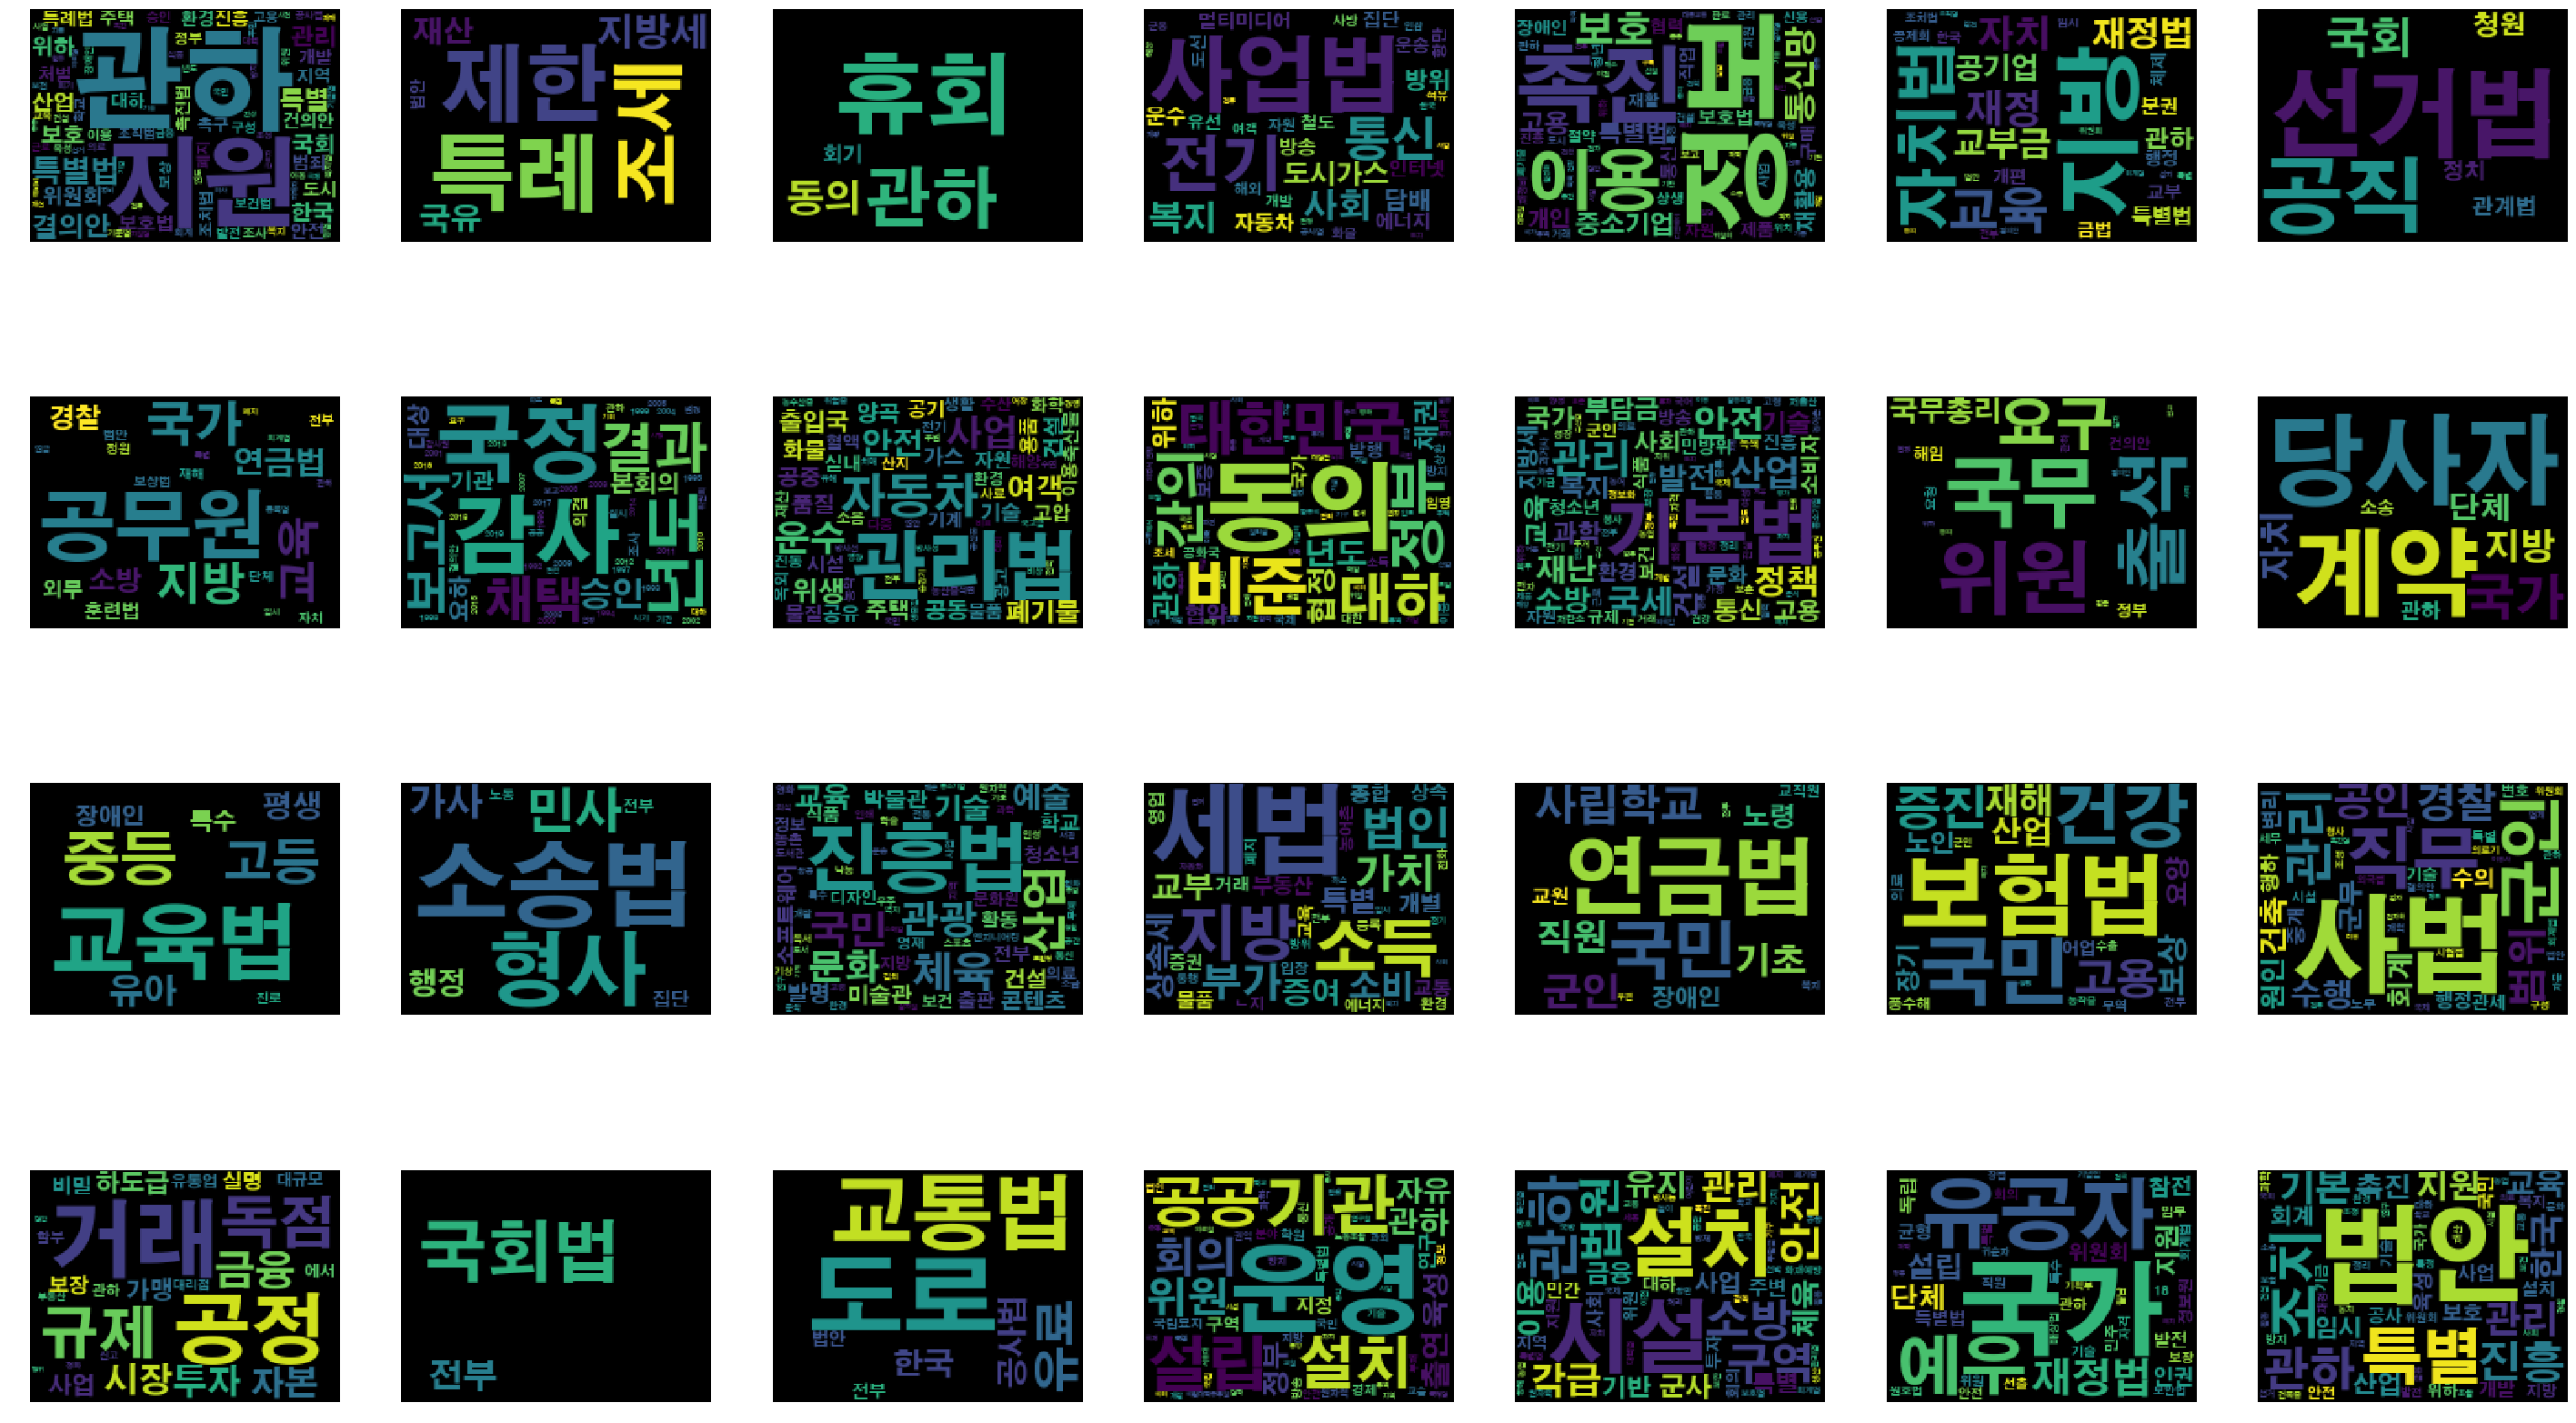

In [44]:
def get_keyword_cluster(dataframe, clusterLabel, col, clusternum):
    temp_dict = {}
    temp = Counter(sum(list(dataframe.loc[df[clusterLabel] == clusternum][col]),[]))
    for i in temp.keys():
        if temp[i] > 1: #하나의 cluster에서 2개 초과로 나타난 단어만 추출
            temp_dict[i] = temp[i]
    return temp_dict

plt.figure(figsize=(50,30))
for num in tqdm(range(clusters_num)):
    temp = get_keyword_cluster(df,'cluster_label','vocab',num )
    plt.subplot(4,7,num+1)
    wc = WordCloud(font_path='C:/Windows/Fonts/H2GTRE.ttf',width=200, height=150).generate_from_frequencies(temp)
    plt.imshow(wc)
    plt.axis('off')

plt.show()


## clustering없이 본회의에서 발의된 전체 법안명을 기준으로 가장 많이 언급된 키워드   
> 그 중 많이 언급된 키워드는 다음과 같았습니다.
  - 특별법, 지원, 법안, 관리, 기본법 ... 


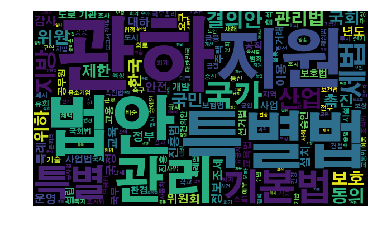

In [45]:
count_df = sum(vocab,[])
count_df = pd.DataFrame(count_df)
count_df.columns = ["word"]
count_df = count_df["word"].value_counts()
temp = WordCloud(font_path='C:/Windows/Fonts/H2GTRE.ttf',width=600, height=350).generate_from_frequencies(count_df)
plt.imshow(temp)
plt.axis('off')
plt.show()

<a id='마무리'></a>
## Ⅲ. 마무리    
  
> - 역사적으로 정치 혼란기에 속했던 국회에서는 국회활동이 상대적으로 빈약했음을 데이터로도 확인할 수 있었습니다.    
> - 최근 국회의원 발의법의안에서는 임기만료폐기 건이 대다수임을 차지하고 있습니다. 국회의원들은 본인들이 발의한 법안에 대해서는 좀더 책임감있게 처리해야 한다고 판단됩니다.
> - 국회의원으로부터 발의되어 본회의에서 처리된 안건들의 가결률은 매우 낮습니다. 정당 간 견제활동인지 질적으로 낮은 법안 발의인지, 원인을 면밀히 파악하여 국회의원들의 발의하는 법안들의 가결률을 높여야 할 필요성이 있습니다.
> - 법안의 주제는 역대 국회별로 차이가 있었습니다. 처리되는 법안의 주제(키워드)를 파악해봄으로써 사회에서 중요시하는 가치관, 사상 등을 파악해보기 쉬울 것입니다.
